<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/K_1_Image_Augmentation_and_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install KerasCV for augmentations
!pip install -q keras-cv --upgrade



In [4]:
# Imports
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [5]:
# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and expand dimensions
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


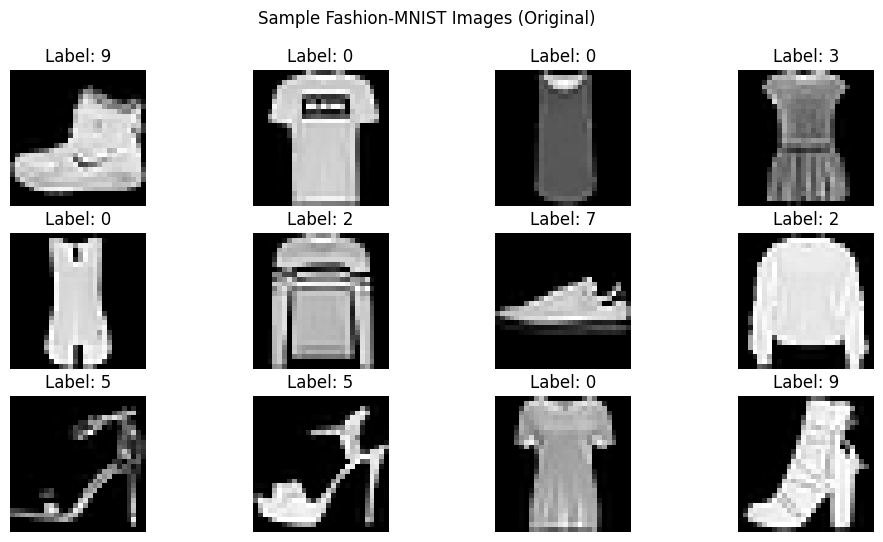

In [6]:
# Plot some sample images
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Sample Fashion-MNIST Images (Original)")
plt.show()


In [9]:
# Prepare basic dataset
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat)).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [12]:
# Create a KerasCV augmentation pipeline
# Corrected Augmentation Setup
cutmix = keras_cv.layers.CutMix(alpha=1.0)
random_flip = keras_cv.layers.RandomFlip(mode="horizontal")

def augment(x, y):
    x = random_flip(x)
    y = tf.cast(y, tf.float32)  # Fix: Cast labels to float32
    output = cutmix({'images': x, 'labels': y})
    return output['images'], output['labels']

train_ds_aug = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


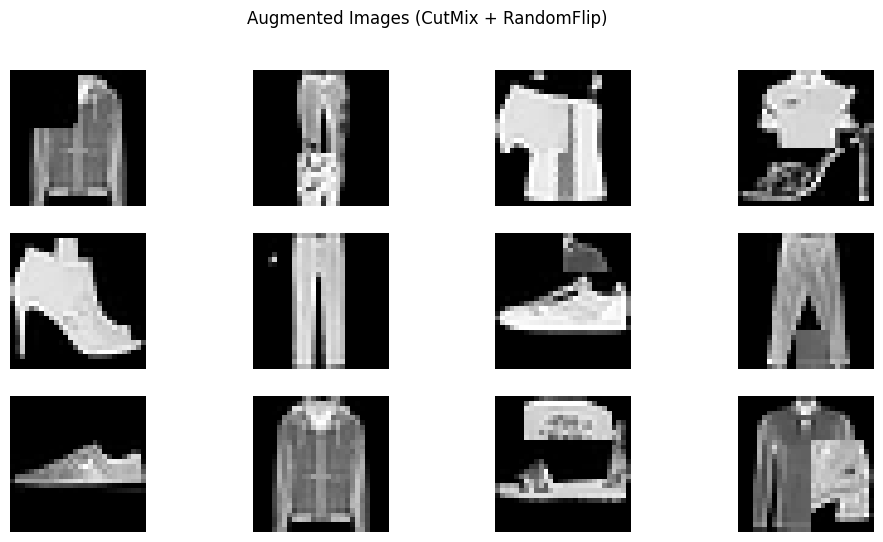

In [13]:
# Visualize some augmented images
for images, labels in train_ds_aug.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Augmented Images (CutMix + RandomFlip)")
    plt.show()


In [14]:
# Define a simple CNN model
def build_cnn_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [15]:
# Train baseline model
model_normal = build_cnn_model()

history_normal = model_normal.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
938/938 - 7s - 8ms/step - accuracy: 0.7974 - loss: 0.5800 - val_accuracy: 0.8438 - val_loss: 0.4395
Epoch 2/10
938/938 - 3s - 3ms/step - accuracy: 0.8447 - loss: 0.4288 - val_accuracy: 0.8547 - val_loss: 0.4038
Epoch 3/10
938/938 - 4s - 4ms/step - accuracy: 0.8585 - loss: 0.3912 - val_accuracy: 0.8592 - val_loss: 0.3867
Epoch 4/10
938/938 - 3s - 3ms/step - accuracy: 0.8646 - loss: 0.3686 - val_accuracy: 0.8670 - val_loss: 0.3689
Epoch 5/10
938/938 - 2s - 2ms/step - accuracy: 0.8714 - loss: 0.3499 - val_accuracy: 0.8654 - val_loss: 0.3748
Epoch 6/10
938/938 - 3s - 3ms/step - accuracy: 0.8745 - loss: 0.3394 - val_accuracy: 0.8747 - val_loss: 0.3499
Epoch 7/10
938/938 - 2s - 2ms/step - accuracy: 0.8792 - loss: 0.3286 - val_accuracy: 0.8700 - val_loss: 0.3567
Epoch 8/10
938/938 - 2s - 2ms/step - accuracy: 0.8814 - loss: 0.3199 - val_accuracy: 0.8771 - val_loss: 0.3435
Epoch 9/10
938/938 - 2s - 2ms/step - accuracy: 0.8855 - loss: 0.3110 - val_accuracy: 0.8762 - val_loss: 0.3505
E

In [16]:
# Train augmented model
model_aug = build_cnn_model()

history_aug = model_aug.fit(
    train_ds_aug,
    validation_data=test_ds,
    epochs=10,
    verbose=2
)


Epoch 1/10
938/938 - 8s - 8ms/step - accuracy: 0.5083 - loss: 1.5817 - val_accuracy: 0.7862 - val_loss: 0.7468
Epoch 2/10
938/938 - 3s - 3ms/step - accuracy: 0.5557 - loss: 1.4674 - val_accuracy: 0.8075 - val_loss: 0.6489
Epoch 3/10
938/938 - 5s - 5ms/step - accuracy: 0.5641 - loss: 1.4332 - val_accuracy: 0.8199 - val_loss: 0.6199
Epoch 4/10
938/938 - 3s - 3ms/step - accuracy: 0.5694 - loss: 1.4139 - val_accuracy: 0.8175 - val_loss: 0.6137
Epoch 5/10
938/938 - 3s - 4ms/step - accuracy: 0.5754 - loss: 1.4019 - val_accuracy: 0.8225 - val_loss: 0.5997
Epoch 6/10
938/938 - 6s - 6ms/step - accuracy: 0.5753 - loss: 1.3937 - val_accuracy: 0.8243 - val_loss: 0.6123
Epoch 7/10
938/938 - 5s - 5ms/step - accuracy: 0.5791 - loss: 1.3855 - val_accuracy: 0.8277 - val_loss: 0.5690
Epoch 8/10
938/938 - 5s - 6ms/step - accuracy: 0.5844 - loss: 1.3772 - val_accuracy: 0.8211 - val_loss: 0.5678
Epoch 9/10
938/938 - 4s - 4ms/step - accuracy: 0.5847 - loss: 1.3795 - val_accuracy: 0.8319 - val_loss: 0.5789
E

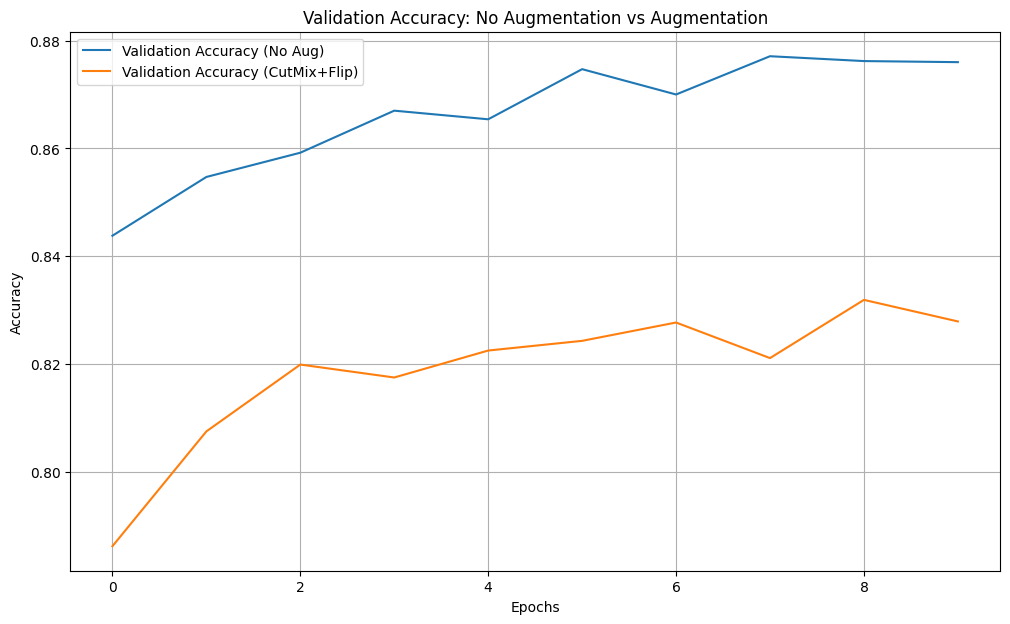

In [17]:
# Plot comparison
plt.figure(figsize=(12, 7))
plt.plot(history_normal.history['val_accuracy'], label="Validation Accuracy (No Aug)")
plt.plot(history_aug.history['val_accuracy'], label="Validation Accuracy (CutMix+Flip)")
plt.title("Validation Accuracy: No Augmentation vs Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [18]:
# Evaluate both models
test_acc_normal = model_normal.evaluate(test_ds, verbose=0)[1]
test_acc_aug = model_aug.evaluate(test_ds, verbose=0)[1]

print(f"Final Test Accuracy (No Augmentation): {test_acc_normal:.4f}")
print(f"Final Test Accuracy (With Augmentation): {test_acc_aug:.4f}")


Final Test Accuracy (No Augmentation): 0.8760
Final Test Accuracy (With Augmentation): 0.8279


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


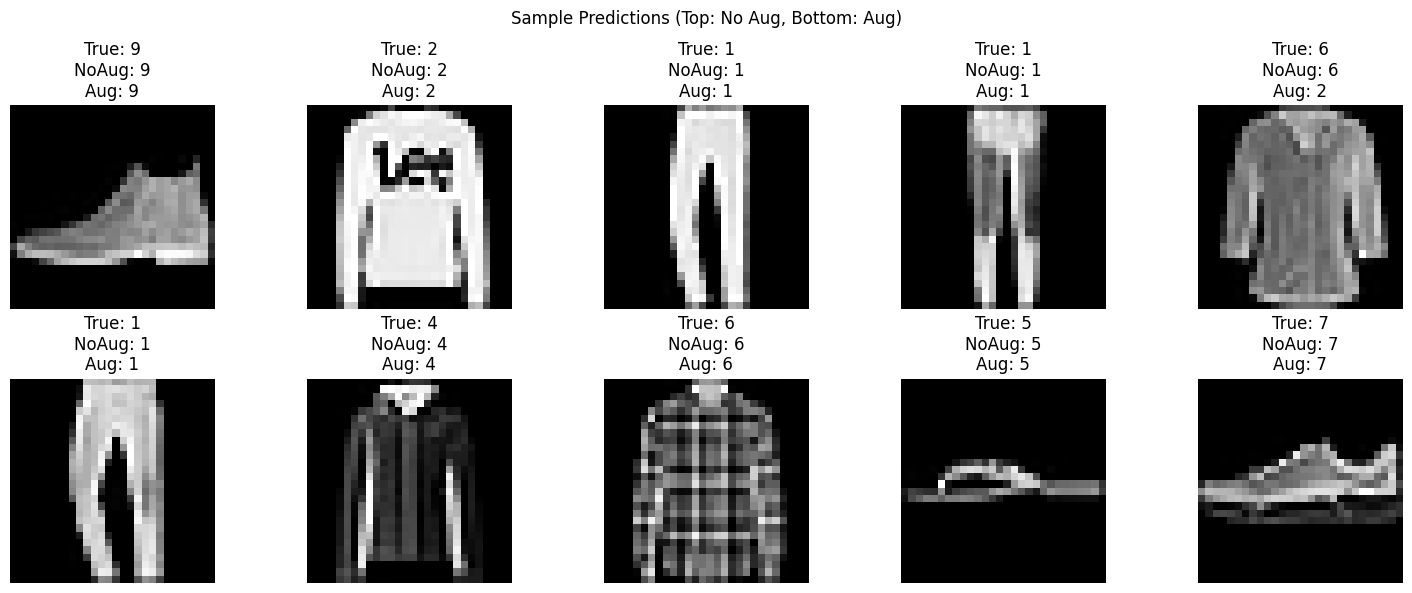

In [19]:
# Predict 10 test samples
x_sample = x_test[:10]
y_sample = y_test[:10]

y_pred_normal = model_normal.predict(x_sample).argmax(axis=1)
y_pred_aug = model_aug.predict(x_sample).argmax(axis=1)

# Visualize sample predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_sample[i].squeeze(), cmap="gray")
    plt.title(f"True: {y_sample[i]}\nNoAug: {y_pred_normal[i]}\nAug: {y_pred_aug[i]}")
    plt.axis('off')
plt.suptitle("Sample Predictions (Top: No Aug, Bottom: Aug)")
plt.tight_layout()
plt.show()


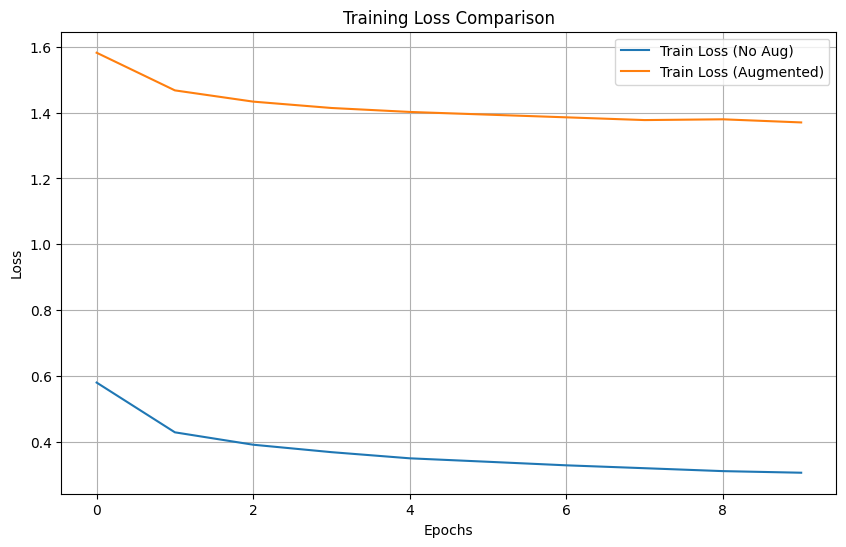

In [20]:
# Plot training loss curves
plt.figure(figsize=(10, 6))
plt.plot(history_normal.history['loss'], label="Train Loss (No Aug)")
plt.plot(history_aug.history['loss'], label="Train Loss (Augmented)")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


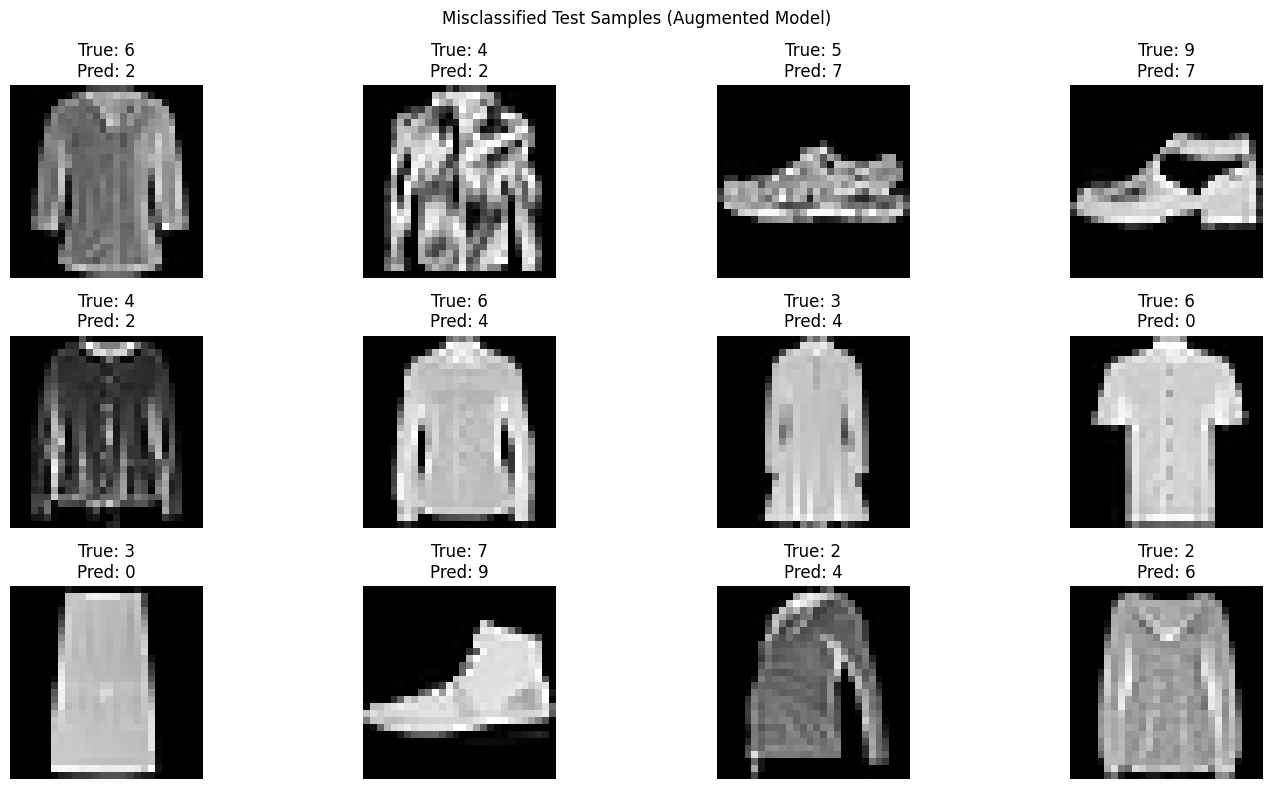

In [21]:
# Predict entire test set
y_test_pred = model_aug.predict(x_test).argmax(axis=1)

# Find wrong predictions
wrong = np.where(y_test_pred != y_test)[0]

# Plot some wrong predictions
plt.figure(figsize=(15, 8))
for i in range(12):
    idx = wrong[i]
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap="gray")
    plt.title(f"True: {y_test[idx]}\nPred: {y_test_pred[idx]}")
    plt.axis('off')
plt.suptitle("Misclassified Test Samples (Augmented Model)")
plt.tight_layout()
plt.show()
